In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/home/mabonnet/Desktop/data/obs_data_2023_finse.csv')

In [3]:
df

,Pit_name,Date,Total_depth,Livox_file,Depth,Density,Temperature_measured,Temperature_corrected
0,1,2023-02-07T10:50:00,105.5,2023.02.07.095639.bin,100,350.0,-1.9,-3.6
1,1,2023-02-07T10:50:00,105.5,2023.02.07.095639.bin,90,290.0,-2.3,-4.0
2,1,2023-02-07T10:50:00,105.5,2023.02.07.095639.bin,80,300.0,-2.7,-4.4
3,1,2023-02-07T10:50:00,105.5,2023.02.07.095639.bin,70,360.0,-3.1,-4.8
4,1,2023-02-07T10:50:00,105.5,2023.02.07.095639.bin,60,380.0,-3.3,-5.0
...,...,...,...,...,...,...,...,...
90,8 – open field,2023-08-02T11:00:00,118.0,None,40,400.0,-0.4,-2.1
91,8 – open field,2023-08-02T11:00:00,118.0,None,30,360.0,0.1,-1.6
92,8 – open field,2023-08-02T11:00:00,118.0,None,20,380.0,0.7,-1.0
93,8 – open field,2023-08-02T11:00:00,118.0,None,10,950.0,1.7,0.0


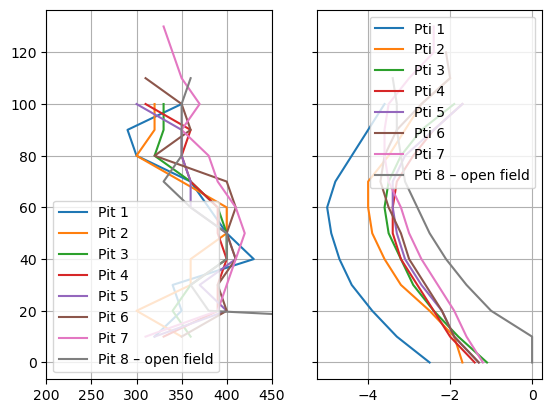

In [8]:
fig, ax = plt.subplots(1,2,sharey=True)
for pit in df.Pit_name.unique():
    tmp = df.loc[df.Pit_name==pit]
    ax[0].plot(tmp.Density,tmp.Depth, label=f'Pit {pit}')
    ax[1].plot(tmp.Temperature_corrected, tmp.Depth, label=f'Pti {pit}')
ax[0].set_xlim(200,450)
ax[0].grid(':')
ax[1].grid(':')
ax[0].legend()
ax[1].legend()

In [15]:
# Pit SWE
df.Density.groupby(df.Pit_name).mean()*(df.Total_depth.groupby(df.Pit_name).mean()/100000)

Pit_name
1                 0.371360
2                 0.380600
3                 0.391310
4                 0.392690
5                 0.394580
6                 0.447273
7                 0.496192
8 – open field    0.492382
dtype: float64

In [16]:
pd.to_datetime('2033.03.12')

Timestamp('2033-03-12 00:00:00')

In [32]:
def get_depth_layers_indices(bottom_depth, sampling_length, depth_array, start_from_top=False):
    '''
    Function that creates an array of the layer index at each (regularly) sampled depth (useful for computing profiles),
    starting from the top or bottom of the snowpack
    Args:
        bottom_depth: depth of the lowest sample, in meters, counted positively from the surface of the snowpack downwards (included) if start_from_top=True,
                      counted positively from the ground upwards if start_from_top=False
        sampling_length: height between two consecutive sampled depths
        depth_array: array of the heights of each layer, in meters, at the end of the simulation
        start_from_top: boolean, is True if the sampling starts at the top of the snowpack (included) downwards, and False if it starts
                        at bottom_depth (included) upwards. Default False
    Returns:
        layers_array: array containing the indices of the layers corresponding to each sampled depth (which layer was sampled)
    '''
    if start_from_top:
        current_layer_index = next(len(depth_array) - i for i, j in enumerate(reversed(depth_array), 1) if j != 0)  # index of top layer
        remaining_depth_in_current_layer = depth_array[current_layer_index]
        current_depth = 0      # from the top of the snowpack
        layers_array = [current_layer_index]    # top of the snowpack
        leftover_depth = sampling_length    # depth to go to the next sample
    
        while current_depth < bottom_depth and current_layer_index > -1:
            while remaining_depth_in_current_layer >= leftover_depth and current_depth < bottom_depth and current_layer_index > -1:   # next sample is in current layer
                layers_array.append(current_layer_index)
                remaining_depth_in_current_layer -= leftover_depth
                current_depth += sampling_length
                leftover_depth = sampling_length
            while remaining_depth_in_current_layer < leftover_depth and current_depth < bottom_depth and current_layer_index > -1:   # next sample is not in current layer
                current_layer_index -= 1   # go to next layer
                leftover_depth -= remaining_depth_in_current_layer   # what is left to "subtract" to this new layer
                remaining_depth_in_current_layer = depth_array[current_layer_index]
                
        layers_array = list(reversed(layers_array))
        
    else: # sampling starts from bottom_depth included
        current_layer_index = 0    # index of bottom layer
        remaining_depth_in_current_layer = depth_array[current_layer_index]
        layers_array = []
        leftover_depth = bottom_depth    # depth to go to the next sample
        
        # Get all other indices
        while current_layer_index < len(depth_array):
            while remaining_depth_in_current_layer >= leftover_depth and current_layer_index < len(depth_array):   # next sample is in current layer
                layers_array.append(current_layer_index)
                remaining_depth_in_current_layer -= leftover_depth
                leftover_depth = sampling_length
            while remaining_depth_in_current_layer < leftover_depth and current_layer_index < len(depth_array):   # next sample is not in current layer
                current_layer_index += 1   # go to next layer
                leftover_depth -= remaining_depth_in_current_layer   # what is left to "subtract" to this new layer
                if current_layer_index < len(depth_array):
                    remaining_depth_in_current_layer = depth_array[current_layer_index]
    
    return(layers_array)

In [19]:
# TODO test the 2 options

In [20]:
layering = [1, 1.2, 0.9, 0.2, 0.3, 0.5, 0.4, 0.75, 1.75]


In [34]:
get_depth_layers_indices(7, 1, layering, start_from_top=True)
# expected [0, 1, 1, 2, 5, 7, 8, 8]

[0, 1, 1, 2, 5, 7, 8, 8]

In [33]:
get_depth_layers_indices(2, 1, layering, start_from_top=False)
# expect [1, 2, 5, 7, 8, 8]

[1, 2, 5, 7, 8, 8]

In [16]:
def get_depth_layers_indices(bottom_depth, sampling_length, depth_array):
    '''
    Function that creates an array of the layer index at each (regularly) sampled depth (useful for computing profiles), starting from the top
    Args:
        bottom_depth: depth of the lowest sample, in meters, counted positively from the surface of the snowpack downwards (included)
        sampling_length: height between two consecutive sampled depths
        depth_array: array of the heights of each layers, in meters, at the end of the simulation
    Returns:
        layers_array: array containing the indices of the layers corresponding to each sampled depth (which layer was sampled)
    '''
    current_layer_index = next(len(depth_array) - i for i, j in enumerate(reversed(depth_array), 1) if j != 0)  # index of top layer
    remaining_depth_in_current_layer = depth_array[current_layer_index]
    current_depth = 0
    layers_array = [current_layer_index]    # top of the snowpack
    leftover_depth = sampling_length
    
    while current_depth < bottom_depth and current_layer_index > -1:
        while remaining_depth_in_current_layer >= sampling_length and current_depth < bottom_depth and current_layer_index > -1:   # next sample is in current layer
            layers_array.append(current_layer_index)
            remaining_depth_in_current_layer -= sampling_length
            current_depth += sampling_length
        while remaining_depth_in_current_layer < leftover_depth and current_depth < bottom_depth and current_layer_index > -1:   # next sample is not in current layer
            current_layer_index -= 1   # go to next layer
            leftover_depth -= remaining_depth_in_current_layer   # what is left to "subtract" to this new layer
            remaining_depth_in_current_layer = depth_array[current_layer_index]
            if remaining_depth_in_current_layer >= leftover_depth and current_layer_index > -1:   # next sample is in current layer
                layers_array.append(current_layer_index)
                remaining_depth_in_current_layer -= leftover_depth
                current_depth += sampling_length
                leftover_depth = sampling_length
                
    layers_array = list(reversed(layers_array))
    
    return(layers_array)

In [17]:
# From previous definition

get_depth_layers_indices(7.8, 1, layering)
# expected [0, 1, 1, 2, 5, 7, 8, 8]

[0, 1, 1, 2, 5, 7, 8, 8]

In [30]:
dmet=pd.read_csv('/home/mabonnet/Desktop/data/Data_2023/finse_meteo_obs.csv')
dmet.time.values[2500:2900]

array(['2023-01-13 02:00:00', '2023-01-13 03:00:00',
       '2023-01-13 04:00:00', '2023-01-13 05:00:00',
       '2023-01-13 06:00:00', '2023-01-13 07:00:00',
       '2023-01-13 08:00:00', '2023-01-13 09:00:00',
       '2023-01-13 10:00:00', '2023-01-13 11:00:00',
       '2023-01-13 12:00:00', '2023-01-13 13:00:00',
       '2023-01-13 14:00:00', '2023-01-13 15:00:00',
       '2023-01-13 16:00:00', '2023-01-13 17:00:00',
       '2023-01-13 18:00:00', '2023-01-13 19:00:00',
       '2023-01-13 20:00:00', '2023-01-13 21:00:00',
       '2023-01-13 22:00:00', '2023-01-13 23:00:00',
       '2023-01-14 00:00:00', '2023-01-14 01:00:00',
       '2023-01-14 02:00:00', '2023-01-14 03:00:00',
       '2023-01-14 04:00:00', '2023-01-14 05:00:00',
       '2023-01-14 06:00:00', '2023-01-14 07:00:00',
       '2023-01-14 08:00:00', '2023-01-14 09:00:00',
       '2023-01-14 10:00:00', '2023-01-14 11:00:00',
       '2023-01-14 12:00:00', '2023-01-14 13:00:00',
       '2023-01-14 14:00:00', '2023-01-14 15:0

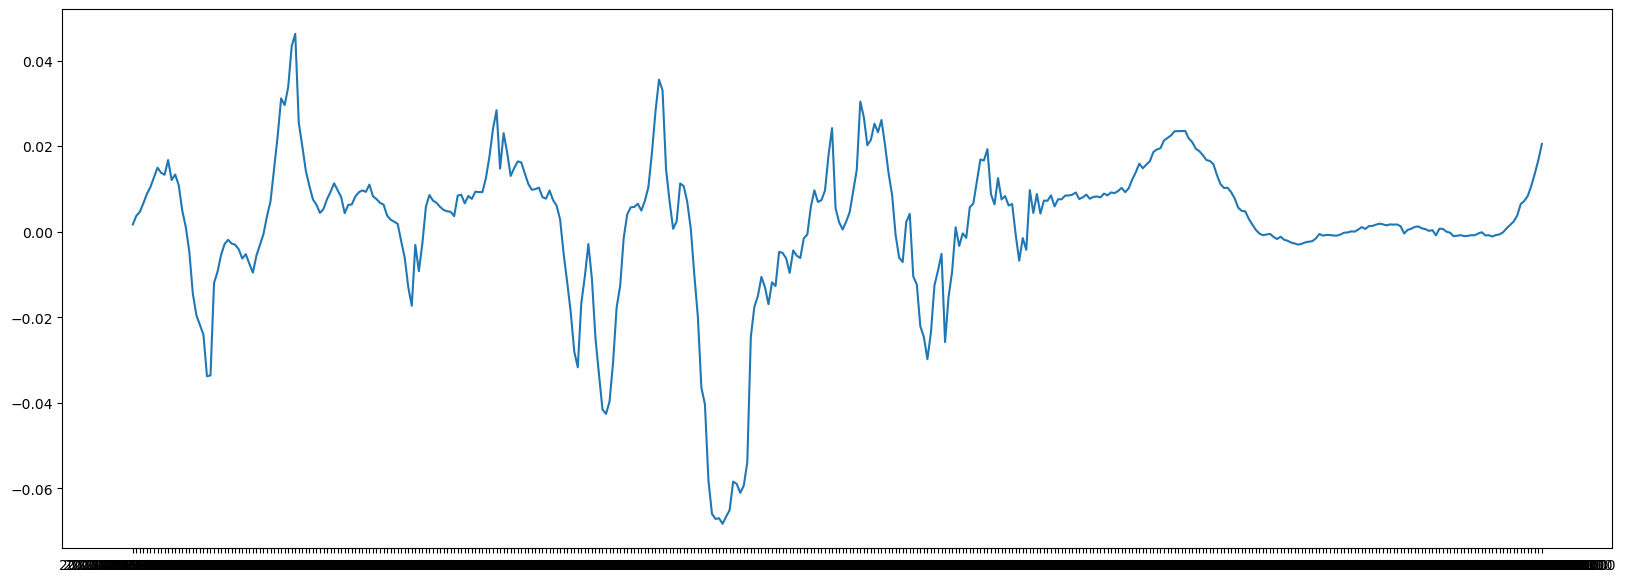

In [35]:
plt.figure(figsize=(20, 7))
plt.plot(dmet['time'].values[2500:2900], dmet.precip.rolling(24).mean().values[2500:2900])
# From Jan. 13th to Jan. 29th approx.